<a href="https://colab.research.google.com/github/eovallemagallanes/Digital-Image-Processing/blob/main/01-INTENSITY-TRANSFORMATION/INTENSITY_TRANSFORMATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REQUIRED PACKAGES

In [1]:
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import FloatSlider

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import skimage
import skimage.color as skic
import skimage.filters as skif
import skimage.data as skid
import skimage.util as sku

## **PLOT FUNCTION**

In [4]:
def show(img, show_hist=True, show_by_channel=False):
    dims = img.shape
    if len(dims) < 2:
        print('Not an image')
        return
    if len(dims) == 2:
        # gray scale image, require aditional last channel
        #print('Expandig last dim')
        img = np.expand_dims(img, -1)
    
    # map to uint8
    img = np.array(img, dtype = np.uint8) 

    channels = img.shape[-1] # last dim is the channel
    if channels == 3:
        labels = ['Red', 'Green', 'Blue']
        colors = ['r', 'g', 'b']
    else:
        labels = ['Gray']
        colors = ['gray']
    if show_hist:
        if show_by_channel and channels == 3:
            fig, axs = plt.subplots(2, channels + 1,
                                       figsize=(12, 6))
            
            # Display original image.
            axs[0, 0].imshow(img)
            axs[0, 0].set_axis_off()
            axs[1, 0].set_axis_off()
            for i in range(channels):
                axs[0, i+1].imshow(img[..., i])
                axs[0, i+1].set_axis_off()

            # Display the histogram.
            for i, (label, color) in enumerate(zip(labels, colors)):
                axs[1, i+1].hist(img[..., i].ravel(), lw=0, bins=256, color=color)
                axs[1, i+1].set_xlim(0, img[..., i].max())
                axs[1, i+1].set(xlabel=label)
                axs[1, i+1].set_yticks([])
        
            plt.show()
        else:
            # Display the image.
            fig, axs = plt.subplots(1, channels + 1,
                                        figsize=(12, 3))
        
            if channels == 3:
                axs[0].imshow(img)
            if channels == 1:
                axs[0].imshow(img[..., 0], cmap='gray')
            axs[0].set_axis_off()
        
            # Display the histogram.
            for i, (label, color) in enumerate(zip(labels, colors)):
                axs[i+1].hist(img[..., i].ravel(), lw=0, bins=256, color=color)
                axs[i+1].set_xlim(0, img[..., i].max())
                axs[i+1].set(xlabel=label)
                axs[i+1].set_yticks([])
        
            plt.show()
    else:
        # Display the image.
        fig = plt.figure(figsize=(3, 3))
        if channels == 3:
            plt.imshow(img)
        if channels == 1:
            plt.imshow(img[..., 0], cmap='gray')
        plt.axis('off')
    


# 01. INTENSITY TRANSFORMATION

## READ IMAGE

In [5]:
# working in range [0.0, 255.0]
img = skimage.img_as_float(skid.astronaut())*255.0

#   The weights used in this conversion are calibrated for contemporary
#   CRT phosphors::
#   Y = 0.2125 R + 0.7154 G + 0.0721 B
#   return values in the range of the input image
gray_img = skic.rgb2gray(img)

## SHOW RGB IMAGE

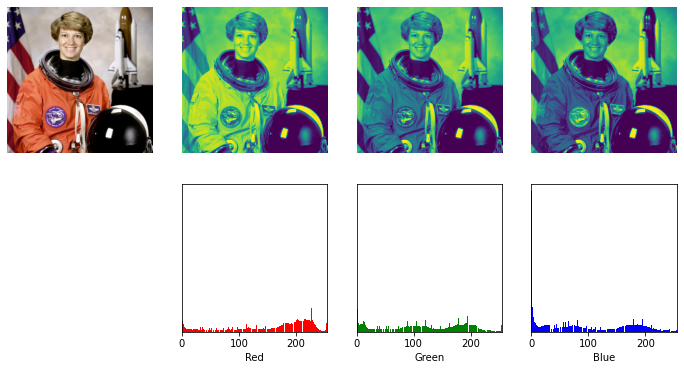

In [6]:
show(img, show_hist=True, show_by_channel=True)

## SHOW GRAY SCALE IMAGE

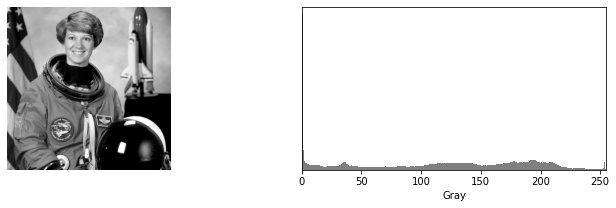

In [7]:
show(gray_img, show_hist=True, show_by_channel=False)

## LINEAR TRANSFORMATION

In [8]:
def trans_lineal(img, Ymin, Ymax):
    print(Ymin, Ymax)
    Imax = img.max()
    Imin = img.min()
    m = (Ymax - Ymin)/(Imax - Imin)
    img_out = m*(img - Imin) + Ymin
    
    show(img_out)
    #return m*(img - Imin) + Ymin

In [9]:
Ymin_widget = FloatSlider(min=0.0, max=255.0, step=1.0, value=0.0, continuous_update=False)
Ymax_widget = FloatSlider(min=0.0, max=255.0, step=1.0, value=255.0, continuous_update=False)

interact(trans_lineal,img=fixed(img), Ymin=Ymin_widget, Ymax=Ymax_widget);

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Ymin', max=255.0, step=1.0)…

## STEP TRANSFORMATION

In [10]:
def trans_step(img, threshold):
    H, W = img.shape[0], img.shape[1]
    #show(img)
    img_out = np.zeros((H, W))
    for i in range(H):
        for j in range(W):
            img_out[i, j] = 1.0 if img[i, j] > threshold else 0.0
    
    show(img_out, show_hist=False)

In [11]:
threshold_widget = FloatSlider(min=0.0, max=255.0, step=1.0, value=90.0, continuous_update=False)

interact(trans_step,img=fixed(gray_img), threshold=threshold_widget);

interactive(children=(FloatSlider(value=90.0, continuous_update=False, description='threshold', max=255.0, ste…

## LOGARITMIC TRASFORMATION

In [12]:
def trans_log(img):
    # Apply log transform. 
    c = 255/(np.log(1 + np.max(img))) 
    log_transformed = c * np.log(1 + img)

    show(log_transformed, show_hist=True)

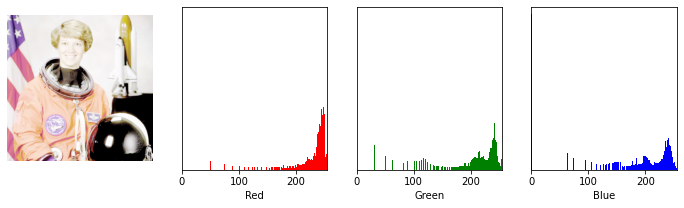

In [13]:
trans_log(img)

## GAMMA TRANSFORMATION

In [14]:
def trans_gamma(img, gamma):
    gamma_corrected = np.array(255*(img / 255) ** gamma) 
    show(gamma_corrected, show_hist=True)

In [15]:
gamma_widget = FloatSlider(min=0.0, max=4.0, step=0.2, value=2.0, continuous_update=False)

interact(trans_gamma,img=fixed(img), gamma=gamma_widget);

interactive(children=(FloatSlider(value=2.0, continuous_update=False, description='gamma', max=4.0, step=0.2),…